# Phase 1 - Libraries Installation

In [ ]:
!pip install pandas numpy scikit-learn xgboost lightgbm matplotlib seaborn

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support, classification_report, mean_absolute_error, mean_squared_error

In [8]:
# Loading data

train = pd.read_csv('/kaggle/input/ctai-ctd-hackathon/train.csv')
test = pd.read_csv('/kaggle/input/ctai-ctd-hackathon/test.csv')

# Phase 2 - EDA

### Basic Dataset Overview

In [9]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [10]:
train.head()

,id,PROJECTNUMBER,MW,PROJECT_CITY,STATE,PROJECT_COUNTRY,CORE_MARKET,PROJECT_TYPE,SIZE_BUILDINGSIZE,NUMFLOORS,...,MasterItemNo,QtyShipped,UOM,ExtendedQuantity,PriceUOM,UnitPrice,ExtendedPrice,CONSTRUCTION_START_DATE,SUBSTANTIAL_COMPLETION_DATE,REVISED_ESTIMATE
0,3478,A0-0070,NaN,Mumbai,Maharashtra,India,Enterprise,Workspace,9000.0,0.0,...,58211,2,can,2,NaN,1983.125,NaN,3/22/2023 0:00,5/25/2023 12:00,2.409524e+07
1,8006,A0-0208,NaN,Delhi,Delhi,India,Wellness,Health Center,31200.0,NaN,...,53691,15,PC,0.15,ML,53273.000,7990.950,11/1/2022 0:00,7/3/2023 12:00,9.511661e+08
2,5748,A0-0004,NaN,Bengaluru,Karnataka,India,Enterprise,Workspace,2800000.0,0.0,...,63311,5,BG,5,BG,864.225,4321.125,2/3/2020 0:00,10/31/2025 0:00,3.492557e+10
3,7898,A0-0166,NaN,Chennai,Tamil Nadu,India,Tertiary Learning,Learning Hub,184000.0,0.0,...,61506,12,EA,12,EA,125.250,1503.000,11/19/2019 0:00,1/24/2025 12:00,1.553978e+10
4,11030,A0-0242,NaN,Hyderabad,Telangana,India,Wellness,Ambulatory Care,25000.0,NaN,...,50921,8,PC,0.128,NaN,NaN,23780.800,12/3/2021 0:00,3/2/2023 12:00,6.867939e+08


In [11]:
test.head()

,id,PROJECTNUMBER,MW,PROJECT_CITY,STATE,PROJECT_COUNTRY,CORE_MARKET,PROJECT_TYPE,SIZE_BUILDINGSIZE,NUMFLOORS,...,invoiceTotal,ItemDescription,UOM,ExtendedQuantity,PriceUOM,UnitPrice,ExtendedPrice,CONSTRUCTION_START_DATE,SUBSTANTIAL_COMPLETION_DATE,REVISED_ESTIMATE
0,3708,A0-0068,NaN,Visakhapatnam,Andhra Pradesh,India,Enterprise,Critical Ops,265850.0,0.0,...,142835.935,"1/4"" x 2"" x 25' Neoprene Gasket",roll,2,NaN,2004.00,NaN,9/12/2022 0:00,10/2/2023 0:00,4.131524e+09
1,6302,A0-0162,NaN,Lucknow,Uttar Pradesh,India,Bio Innovation,R&amp;D Laboratories,288000.0,0.0,...,1393673.450,"4"" x 14'2"" C-H Stud 20ga 33mil",PC,1.275,ML,140280.00,178857.835,5/6/2022 0:00,5/30/2025 0:00,1.559882e+10
2,8687,A0-0219,NaN,Indore,Madhya Pradesh,India,Misc Market,Learning Hub,40000.0,2.0,...,1446021.270,"6"" ProX Header Clip 16ga 54mil",EA,36,EA,165.33,5951.880,12/14/2021 0:00,11/17/2023 12:00,3.600137e+09
3,361,A0-0005,NaN,Warangal,Telangana,India,Misc Market,Learning Hub,36700.0,4.0,...,10460.880,"3/4""X16""X21"" SDS MAX ROTARY HAMMER\nDRILL SPEE...",NaN,NaN,NaN,4178.34,8356.680,10/15/2020 0:00,1/11/2024 12:00,3.422320e+09
4,13231,A0-0023,NaN,Kolkata,West Bengal,India,Enterprise,Hospitality Hall,435000.0,11.0,...,192062.525,"6"" x 10' Flat Strap 16ga 54mil",PC,0.22,ML,157230.50,34590.710,8/15/2022 0:00,1/21/2025 0:00,2.320456e+10


In [12]:
# Number of rows and columns
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (14036, 26)
Test shape: (2685, 24)


In [13]:
# Basic info
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14036 entries, 0 to 14035
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           14036 non-null  int64  
 1   PROJECTNUMBER                14036 non-null  object 
 2   MW                           3300 non-null   float64
 3   PROJECT_CITY                 14036 non-null  object 
 4   STATE                        14036 non-null  object 
 5   PROJECT_COUNTRY              14036 non-null  object 
 6   CORE_MARKET                  14036 non-null  object 
 7   PROJECT_TYPE                 14034 non-null  object 
 8   SIZE_BUILDINGSIZE            14006 non-null  float64
 9   NUMFLOORS                    9587 non-null   float64
 10  NUMROOMS                     6744 non-null   float64
 11  NUMBEDS                      5909 non-null   float64
 12  invoiceId                    14036 non-null  object 
 13  invoiceDate     

In [14]:
# count of missing values per column
train.isna().sum()

id                                 0
PROJECTNUMBER                      0
MW                             10736
PROJECT_CITY                       0
STATE                              0
PROJECT_COUNTRY                    0
CORE_MARKET                        0
PROJECT_TYPE                       2
SIZE_BUILDINGSIZE                 30
NUMFLOORS                       4449
NUMROOMS                        7292
NUMBEDS                         8127
invoiceId                          0
invoiceDate                        0
invoiceTotal                     265
ItemDescription                    0
MasterItemNo                       0
QtyShipped                        35
UOM                             1647
ExtendedQuantity                1867
PriceUOM                        3957
UnitPrice                         13
ExtendedPrice                   2522
CONSTRUCTION_START_DATE            0
SUBSTANTIAL_COMPLETION_DATE        0
REVISED_ESTIMATE                   0
dtype: int64

In [15]:
# Check missing values & percentage
# It produces a two‑column DataFrame showing, for each original column, the count of missing values and the percentage of missing values relative to the row count.

pd.concat([train.isnull().sum(), (train.isnull().sum()/len(train))*100], axis=1)

,0,1
id,0,0.000000
PROJECTNUMBER,0,0.000000
MW,10736,76.489028
PROJECT_CITY,0,0.000000
STATE,0,0.000000
PROJECT_COUNTRY,0,0.000000
CORE_MARKET,0,0.000000
PROJECT_TYPE,2,0.014249
SIZE_BUILDINGSIZE,30,0.213736
NUMFLOORS,4449,31.697065


In [16]:
# Statistical summary of numerical columns
train.describe()

,id,MW,SIZE_BUILDINGSIZE,NUMFLOORS,NUMROOMS,NUMBEDS,invoiceTotal,UnitPrice,ExtendedPrice,REVISED_ESTIMATE
count,14036.000000,3300.000000,1.400600e+04,9587.000000,6744.000000,5909.000000,1.377100e+04,1.402300e+04,1.151400e+04,1.403600e+04
mean,8679.273867,24.000000,3.761221e+05,4.765516,89.984134,24.449484,2.328752e+08,2.637003e+05,7.685337e+06,1.413049e+10
std,4920.643344,9.934615,6.011375e+05,5.723230,180.626871,55.284535,7.907379e+08,3.812952e+06,9.121675e+07,1.730003e+10
min,2.000000,10.000000,0.000000e+00,0.000000,0.000000,0.000000,-9.132061e+06,-3.022617e+04,-8.611215e+06,2.317793e+06
25%,4419.750000,10.000000,4.900000e+04,0.000000,0.000000,0.000000,9.550563e+04,4.090665e+03,1.295920e+04,2.795749e+09
50%,8772.500000,30.000000,1.840000e+05,4.000000,0.000000,0.000000,3.460866e+05,3.924500e+04,5.260500e+04,9.895474e+09
75%,13153.250000,32.000000,4.350000e+05,7.000000,0.000000,0.000000,3.487244e+06,1.081325e+05,7.083205e+05,2.295572e+10
max,16721.000000,32.000000,3.900000e+06,41.000000,500.000000,500.000000,7.056846e+09,1.942341e+08,3.454918e+09,1.340000e+11


In [17]:
# Missing values with counts, percentage, and dtype
missing = train.isna().sum()
missing = missing[missing > 0]

missing_info = pd.DataFrame({
    "MissingCount": missing,
    "MissingPercentage": (missing / len(train) * 100).round(2),
    "Datatype": train.dtypes[missing.index]
})

print(missing_info)

                   MissingCount  MissingPercentage Datatype
MW                        10736              76.49  float64
PROJECT_TYPE                  2               0.01   object
SIZE_BUILDINGSIZE            30               0.21  float64
NUMFLOORS                  4449              31.70  float64
NUMROOMS                   7292              51.95  float64
NUMBEDS                    8127              57.90  float64
invoiceTotal                265               1.89  float64
QtyShipped                   35               0.25   object
UOM                        1647              11.73   object
ExtendedQuantity           1867              13.30   object
PriceUOM                   3957              28.19   object
UnitPrice                    13               0.09  float64
ExtendedPrice              2522              17.97  float64


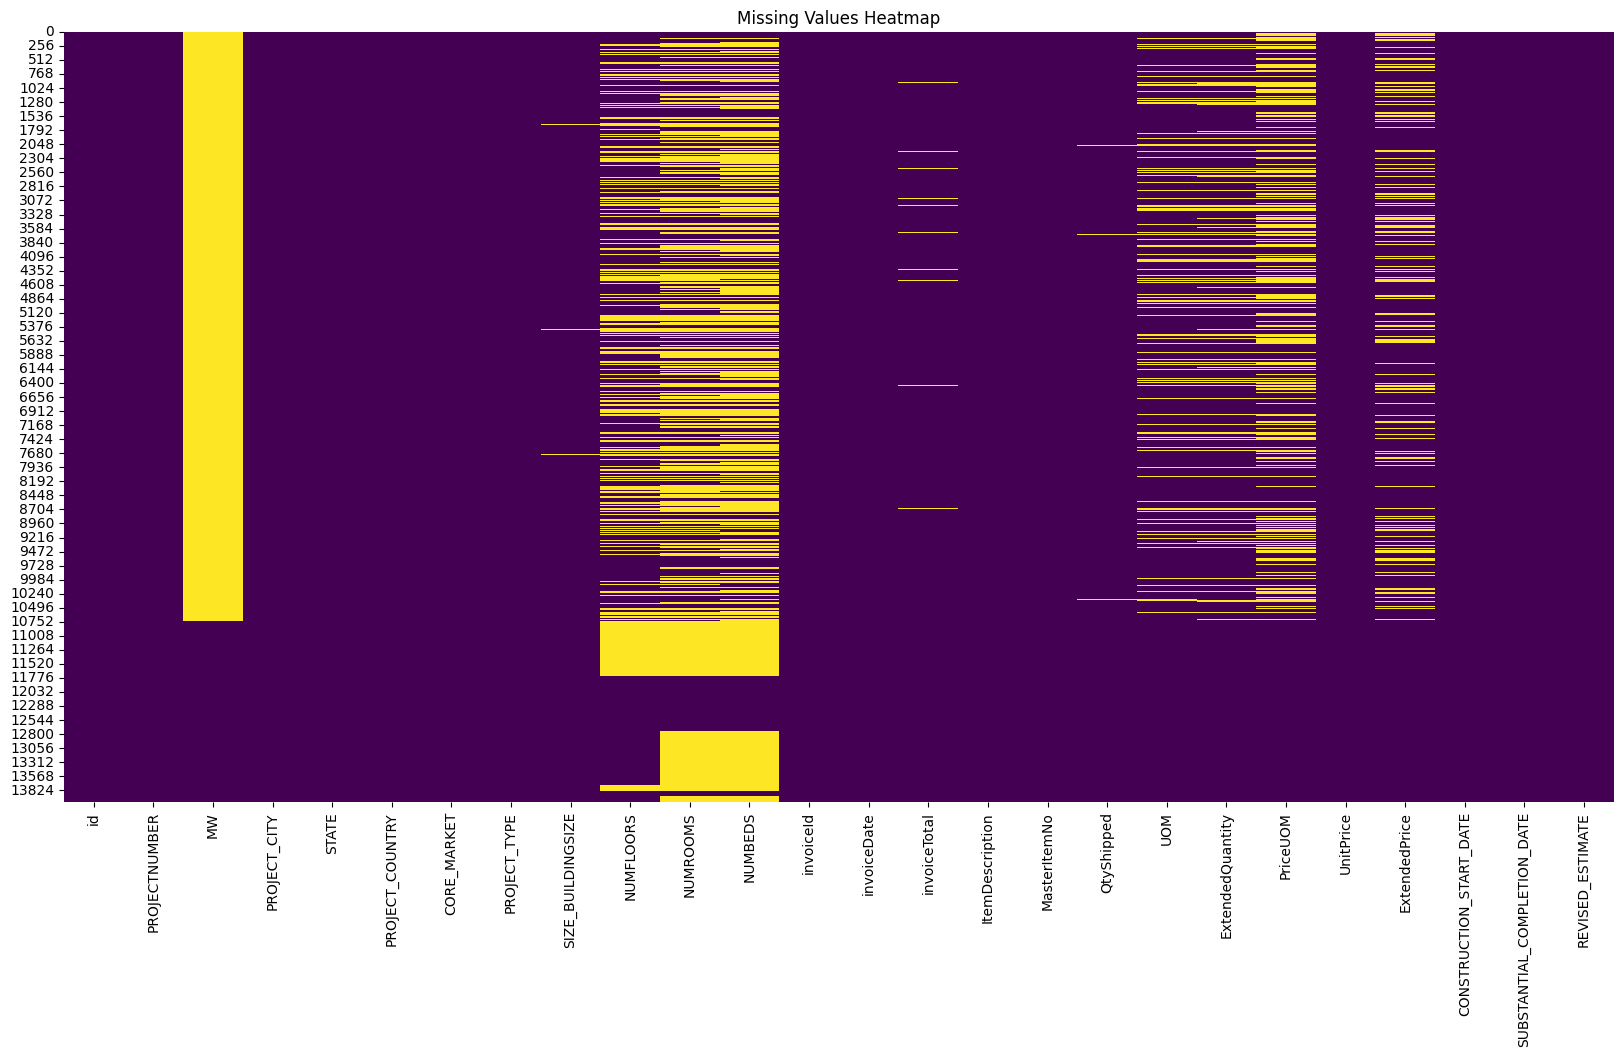

In [18]:
# Visualize missing data

plt.figure(figsize=(20,10))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

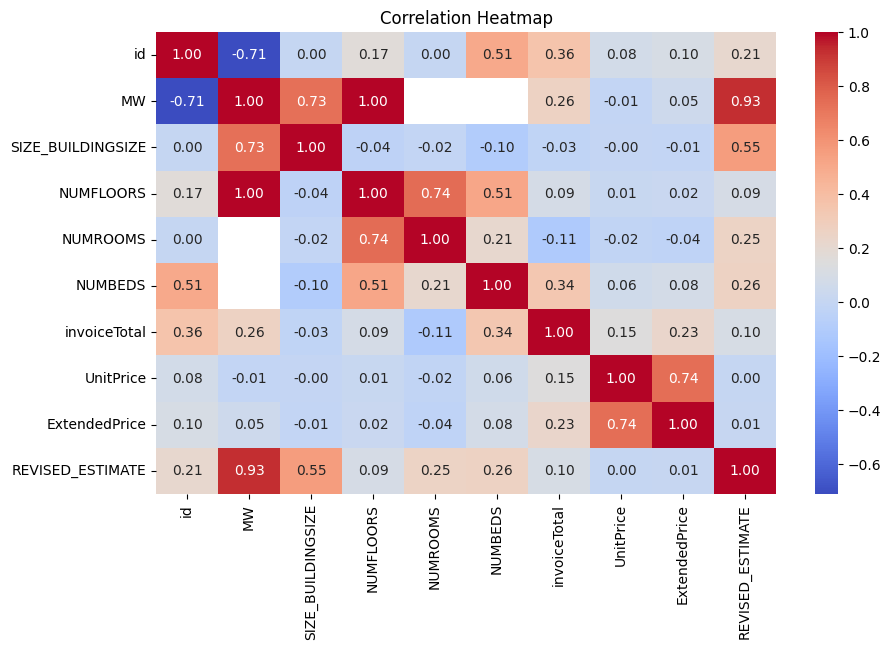

In [19]:
# Correlation heatmap
numeric_cols = train.select_dtypes(include=['int64','float64']).columns
plt.figure(figsize=(10,6))
sns.heatmap(train[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

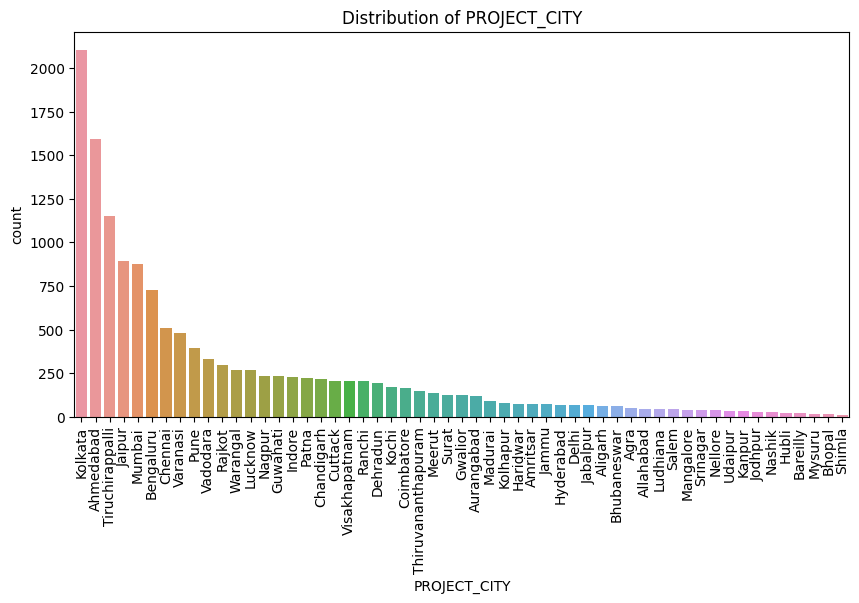

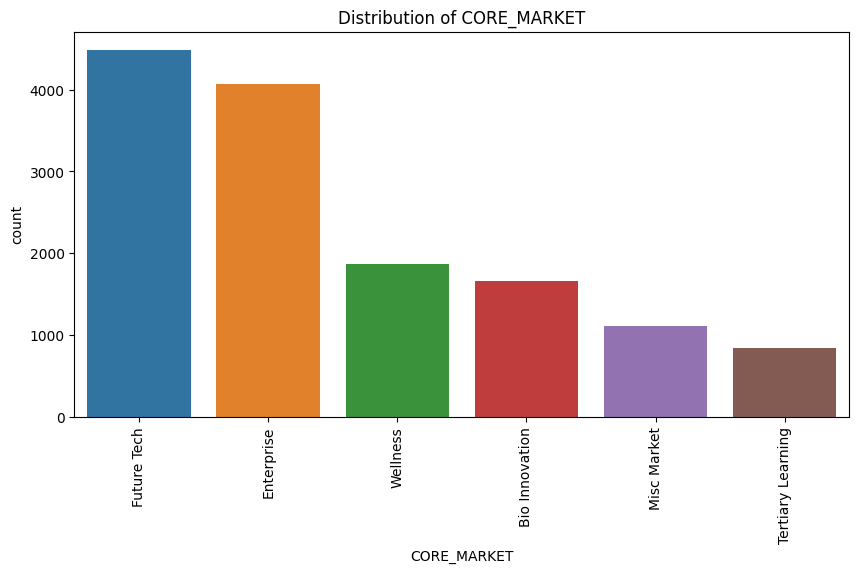

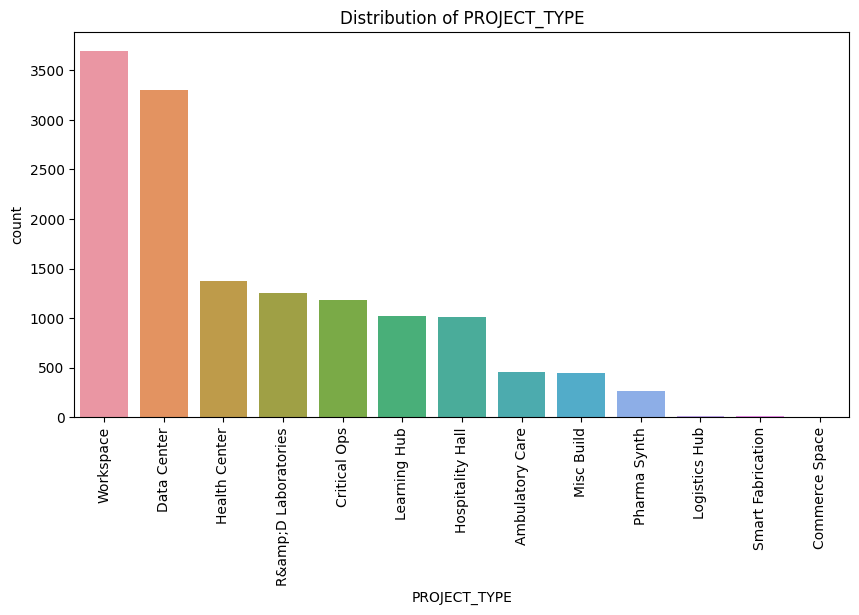

In [20]:
# Count plots for categorical variables
categorical_cols = ['PROJECT_CITY','CORE_MARKET','PROJECT_TYPE']

for col in categorical_cols:
    plt.figure(figsize=(10,5))
    sns.countplot(x=train[col], order=train[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=90)
    plt.show()


# Phase 3 – Feature Engineering & Data Preprocessing

In [21]:
# convert column from object to string
train["PROJECTNUMBER"] = train["PROJECTNUMBER"].astype(str)
train["PROJECT_CITY"] = train["PROJECT_CITY"].astype(str)
train["STATE"] = train["STATE"].astype(str)
train["PROJECT_COUNTRY"] = train["PROJECT_COUNTRY"].astype(str)
train["CORE_MARKET"] = train["CORE_MARKET"].astype(str)
train["PROJECT_TYPE"] = train["PROJECT_TYPE"].astype(str)
train["invoiceId"] = train["invoiceId"].astype(str)
train["ItemDescription"] = train["ItemDescription"].astype(str)
train["MasterItemNo"] = train["MasterItemNo"].astype(str)
train["UOM"] = train["UOM"].astype(str)
train["ExtendedQuantity"] = train["ExtendedQuantity"].astype(str)
train["PriceUOM"] = train["PriceUOM"].astype(str)

test["PROJECTNUMBER"] = test["PROJECTNUMBER"].astype(str)
test["PROJECT_CITY"] = test["PROJECT_CITY"].astype(str)
test["STATE"] = test["STATE"].astype(str)
test["PROJECT_COUNTRY"] = test["PROJECT_COUNTRY"].astype(str)
test["CORE_MARKET"] = test["CORE_MARKET"].astype(str)
test["PROJECT_TYPE"] = test["PROJECT_TYPE"].astype(str)
test["invoiceId"] = test["invoiceId"].astype(str)
test["ItemDescription"] = test["ItemDescription"].astype(str)
test["UOM"] = test["UOM"].astype(str)
test["ExtendedQuantity"] = test["ExtendedQuantity"].astype(str)
test["PriceUOM"] = test["PriceUOM"].astype(str)

# convert column from object to float
def clean_qtyshipped(val):
    if pd.isna(val):
        return None
    val = str(val).replace(",", "")  # remove commas
    # Case 1: If contains '=', take the number after '='
    if "=" in val:
        match = re.search(r"=\s*(\d+\.?\d*)", val)
        if match:
            return float(match.group(1))
    # Case 2: Otherwise, extract the first valid number
    match = re.search(r"\d+\.?\d*", val)
    if match:
        return float(match.group())
    return None  # if no number found
# Apply cleaning
train["QtyShipped"] = train["QtyShipped"].apply(clean_qtyshipped)


# convert column from object to datetime
def parse_date(val):
    if pd.isna(val):
        return None
    try:
        # Try parsing with timestamp format
        return pd.to_datetime(val, format="%d-%m-%Y %H:%M:%S", errors="raise")
    except:
        try:
            # Try parsing with simple date format
            return pd.to_datetime(val, format="%d-%m-%Y", errors="raise")
        except:
            # Fallback: let pandas guess
            return pd.to_datetime(val, errors="coerce", dayfirst=True)
# Apply to columns
date_cols = ["invoiceDate"]
for col in date_cols:
    train[col] = train[col].apply(parse_date)
    test[col] = test[col].apply(parse_date)

# Convert to datetime
train["CONSTRUCTION_START_DATE"] = pd.to_datetime(train["CONSTRUCTION_START_DATE"], errors="coerce")
train["SUBSTANTIAL_COMPLETION_DATE"] = pd.to_datetime(train["SUBSTANTIAL_COMPLETION_DATE"], errors="coerce")

test["CONSTRUCTION_START_DATE"] = pd.to_datetime(test["CONSTRUCTION_START_DATE"], errors="coerce")
test["SUBSTANTIAL_COMPLETION_DATE"] = pd.to_datetime(test["SUBSTANTIAL_COMPLETION_DATE"], errors="coerce")

# Now compute project duration in days
train["project_duration"] = (train["SUBSTANTIAL_COMPLETION_DATE"] - train["CONSTRUCTION_START_DATE"]).dt.days
test["project_duration"] = (test["SUBSTANTIAL_COMPLETION_DATE"] - test["CONSTRUCTION_START_DATE"]).dt.days

/tmp/ipykernel_36/960817534.py:59: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(val, errors="coerce", dayfirst=True)
/tmp/ipykernel_36/960817534.py:59: UserWarning: Parsing dates in %m/%d/%Y %H:%M format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(val, errors="coerce", dayfirst=True)


In [22]:
train["is_data_centre"] = train["MW"].notna().astype(int)
train["project_duration"] = (train["SUBSTANTIAL_COMPLETION_DATE"] - train["CONSTRUCTION_START_DATE"]).dt.days

test["is_data_centre"] = test["MW"].notna().astype(int)
test["project_duration"] = (test["SUBSTANTIAL_COMPLETION_DATE"] - test["CONSTRUCTION_START_DATE"]).dt.days

train["BUILDING_SIZE_CAT"] = pd.cut(
    train["SIZE_BUILDINGSIZE"],
    bins=[0, 5000, 20000, 50000, 100000, float("inf")],
    labels=["Tiny", "Small", "Medium", "Large", "Mega"]
)

test["BUILDING_SIZE_CAT"] = pd.cut(
    test["SIZE_BUILDINGSIZE"],
    bins=[0, 5000, 20000, 50000, 100000, float("inf")],
    labels=["Tiny", "Small", "Medium", "Large", "Mega"]
)

# Extract season from invoiceDate
def get_season(month):
    if month in [12,1,2]:
        return "Winter"
    elif month in [3,4,5]:
        return "Summer"
    elif month in [6,7,8,9]:
        return "Monsoon"
    else:
        return "Autumn"
train["invoiceDate"] = pd.to_datetime(train["invoiceDate"], errors="coerce", dayfirst=True)
train["invoice_month"] = train["invoiceDate"].dt.month
train["invoice_season"] = train["invoice_month"].apply(get_season)

In [23]:
def get_season(month):
    if month in [12,1,2]:
        return "Winter"
    elif month in [3,4,5]:
        return "Summer"
    elif month in [6,7,8,9]:
        return "Monsoon"
    else:
        return "Autumn"

train["invoiceDate"] = pd.to_datetime(train["invoiceDate"], errors="coerce", dayfirst=True)
train["invoice_month"] = train["invoiceDate"].dt.month
train["invoice_season"] = train["invoice_month"].apply(get_season)

test["invoiceDate"] = pd.to_datetime(test["invoiceDate"], errors="coerce", dayfirst=True)
test["invoice_month"] = test["invoiceDate"].dt.month
test["invoice_season"] = test["invoice_month"].apply(get_season)

train["SIZE_BUILDINGSIZE"] = train["SIZE_BUILDINGSIZE"].fillna(train["SIZE_BUILDINGSIZE"].median())
train['total_qty_per_project'] = train.groupby('PROJECTNUMBER')['QtyShipped'].transform('sum')
train['total_price_per_project'] = train.groupby('PROJECTNUMBER')['ExtendedPrice'].transform('sum')

test["SIZE_BUILDINGSIZE"] = test["SIZE_BUILDINGSIZE"].fillna(test["SIZE_BUILDINGSIZE"].median())
test['total_price_per_project'] = test.groupby('PROJECTNUMBER')['ExtendedPrice'].transform('sum')


In [24]:
from sklearn.preprocessing import LabelEncoder

low_card_cols = ["CORE_MARKET","BUILDING_SIZE_CAT","invoice_season"]
train = pd.get_dummies(train, columns=low_card_cols, drop_first=True)
test = pd.get_dummies(test, columns=low_card_cols, drop_first=True)

le = LabelEncoder()
high_card_cols = ["PROJECT_CITY","STATE","PROJECT_TYPE","PROJECTNUMBER","SUBSTANTIAL_COMPLETION_DATE","CONSTRUCTION_START_DATE","UOM"]

for col in high_card_cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.fit_transform(test[col])

# Phase 4 - Model Testing

In [25]:
# ================================
# STEP 1: Define columns to drop
# ================================
cols_to_drop = [
    "id", "PROJECT_COUNTRY", "SIZE_BUILDINGSIZE", "NUMBEDS", "invoiceId",
    "MasterItemNo", "QtyShipped", "ExtendedQuantity", "REVISED_ESTIMATE",
    "PriceUOM", "invoiceDate", "invoiceTotal", "NUMROOMS", 
    "ItemDescription", "invoice_month"
]

# Keep MW only for data-centre
cols_to_drop_non_dc = cols_to_drop + ["MW"]


In [26]:
# ================================
# STEP 2: Split dataset by is_data_centre
# ================================
train_dc = train[train["is_data_centre"] == 1].copy()
train_non_dc = train[train["is_data_centre"] == 0].copy()

test_dc = test[test["is_data_centre"] == 1].copy()
test_non_dc = test[test["is_data_centre"] == 0].copy()


print(f"Data Centre: {len(train_dc)} train, {len(test_dc)} test")
print(f"Non-Data Centre: {len(train_non_dc)} train, {len(test_non_dc)} test")

Data Centre: 3300 train, 0 test
Non-Data Centre: 10736 train, 2685 test


In [27]:
# ================================
# STEP 3: Configuration - Choose Model Strategy
# ================================

# Set this to True to use LightGBM for Non-Data Centre (much faster)
# Set this to False to use original CatBoost GPU for both (may cause memory issues)
USE_LIGHTGBM_FOR_NON_DC = False

print(f"Strategy: {'LightGBM for Non-DC' if USE_LIGHTGBM_FOR_NON_DC else 'CatBoost GPU for both'}")

Strategy: CatBoost GPU for both


In [28]:
# ================================
# STEP 4: Training Functions
# ================================
def train_classifier_cat(train_df, cols_to_drop, with_mw=True):
    X = train_df.drop(cols_to_drop, axis=1)
    y = train_df["MasterItemNo"].astype(str).fillna("Unknown")

    classes = np.unique(y)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y)
    class_weights = dict(zip(classes, weights))

    clf = CatBoostClassifier(
        iterations=500, depth=8, learning_rate=0.1,
        loss_function="MultiClass", random_seed=42,
        class_weights=class_weights, task_type="GPU", verbose=100
    )
    clf.fit(X, y)
    preds = clf.predict(X)
    print(f"{'DC' if with_mw else 'Non-DC'} Classification | Acc={accuracy_score(y, preds):.3f}, F1={f1_score(y, preds, average='weighted'):.3f}")
    return clf

def train_regressor_cat(train_df, cols_to_drop):
    reg_data = train_df.dropna(subset=["QtyShipped"]).copy()
    reg_data["calc_qty"] = reg_data["ExtendedPrice"] / reg_data["UnitPrice"]
    reg_data["total_capacity"] = reg_data["NUMROOMS"].fillna(0) + reg_data["NUMBEDS"].fillna(0)
    reg_data["duration_days"] = (pd.to_datetime(reg_data["SUBSTANTIAL_COMPLETION_DATE"], errors="coerce") -
                                 pd.to_datetime(reg_data["CONSTRUCTION_START_DATE"], errors="coerce")).dt.days.fillna(0)
    reg_data["price_per_unit_area"] = reg_data["ExtendedPrice"] / (reg_data["SIZE_BUILDINGSIZE"].fillna(1))

    cap_value = np.percentile(reg_data["QtyShipped"].dropna(), 99)
    reg_data["QtyShipped"] = np.where(reg_data["QtyShipped"] > cap_value, cap_value, reg_data["QtyShipped"])

    y = np.log1p(reg_data["QtyShipped"])
    X = reg_data.drop(cols_to_drop, axis=1)

    reg = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=8,
                            loss_function="RMSE", random_seed=42,
                            task_type="GPU", verbose=100)
    reg.fit(X, y)
    preds = np.expm1(reg.predict(X))
    mae = mean_absolute_error(np.expm1(y), preds)
    print(f"Regression (CatBoost) | MAE={mae:.2f}")
    return reg


In [29]:
# ================================
# STEP 5: Training Functions (LightGBM)
# ================================
def train_classifier_lgb(train_df, cols_to_drop):
    X = train_df.drop(cols_to_drop, axis=1)
    y = train_df["MasterItemNo"].astype(str).fillna("Unknown")

    class_counts = pd.Series(y).value_counts()
    valid_classes = class_counts[class_counts >= 2].index
    mask = pd.Series(y).isin(valid_classes)
    X, y = X[mask], pd.Series(y)[mask].values

    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, random_state=42)

    params = {
    'objective': 'multiclass',
    'num_class': len(le.classes_),
    'metric': 'multi_logloss',
    'is_unbalance': True,   # ⚡ auto-balance
    'learning_rate': 0.05,
    'num_leaves': 64,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'random_state': 42,
    'verbose': -1
    }


    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    clf = lgb.train(params, train_data, valid_sets=[val_data],
                    num_boost_round=300, callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)])
    
    # ✅ Save feature list
    clf.feature_name_ = list(X.columns)

    preds_enc = clf.predict(X)
    preds = le.inverse_transform(np.argmax(preds_enc, axis=1))
    print(f"Non-DC Classification (LightGBM) | Acc={accuracy_score(y, preds):.3f}, F1={f1_score(y, preds, average='weighted'):.3f}")
    return clf, le


def train_regressor_lgb(train_df, cols_to_drop):
    reg_data = train_df.dropna(subset=["QtyShipped"]).copy()
    reg_data["calc_qty"] = reg_data["ExtendedPrice"] / reg_data["UnitPrice"]
    reg_data["total_capacity"] = reg_data["NUMROOMS"].fillna(0) + reg_data["NUMBEDS"].fillna(0)
    reg_data["duration_days"] = (pd.to_datetime(reg_data["SUBSTANTIAL_COMPLETION_DATE"], errors="coerce") -
                                 pd.to_datetime(reg_data["CONSTRUCTION_START_DATE"], errors="coerce")).dt.days.fillna(0)
    reg_data["price_per_unit_area"] = reg_data["ExtendedPrice"] / (reg_data["SIZE_BUILDINGSIZE"].fillna(1))

    cap_value = np.percentile(reg_data["QtyShipped"].dropna(), 99)
    reg_data["QtyShipped"] = np.where(reg_data["QtyShipped"] > cap_value, cap_value, reg_data["QtyShipped"])

    y = np.log1p(reg_data["QtyShipped"])
    X = reg_data.drop(cols_to_drop, axis=1)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    params = {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.05,
              'num_leaves': 31, 'feature_fraction': 0.8, 'bagging_fraction': 0.8,
              'bagging_freq': 5, 'random_state': 42, 'verbose': -1}

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    reg = lgb.train(params, train_data, valid_sets=[val_data], num_boost_round=400,
                    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)])

    # ✅ Save feature list
    reg.feature_name_ = list(X.columns)

    preds = np.expm1(reg.predict(X))
    mae = mean_absolute_error(np.expm1(y), preds)
    print(f"Regression (LightGBM) | MAE={mae:.2f}")
    return reg



In [30]:
# ================================
# STEP 6: Train Models
# ================================
print("\nTraining DC models...")
clf_dc = train_classifier_cat(train_dc, cols_to_drop, with_mw=True)
reg_dc = train_regressor_cat(train_dc, cols_to_drop)

print("\nTraining Non-DC models...")
clf_non_dc, le_non_dc = train_classifier_lgb(train_non_dc, cols_to_drop_non_dc)
reg_non_dc = train_regressor_lgb(train_non_dc, cols_to_drop_non_dc)


Training DC models...
0:	learn: 3.3590540	total: 405ms	remaining: 3m 22s
100:	learn: 0.6456184	total: 6.06s	remaining: 24s
200:	learn: 0.4654126	total: 11.6s	remaining: 17.3s
300:	learn: 0.3805855	total: 17.2s	remaining: 11.4s
400:	learn: 0.3341583	total: 22.9s	remaining: 5.64s
499:	learn: 0.2953325	total: 28.4s	remaining: 0us
DC Classification | Acc=0.901, F1=0.899
0:	learn: 1.8560577	total: 154ms	remaining: 1m 16s
100:	learn: 0.0553481	total: 1.61s	remaining: 6.38s
200:	learn: 0.0452873	total: 2.65s	remaining: 3.93s
300:	learn: 0.0434212	total: 3.34s	remaining: 2.21s
400:	learn: 0.0423346	total: 4.01s	remaining: 991ms
499:	learn: 0.0414387	total: 4.64s	remaining: 0us
Regression (CatBoost) | MAE=27.77

Training Non-DC models...
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 32.8943
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 8.72523
Non-DC Classification (LightGBM) | Acc=0.179, F1=0.157
Training until validation scores d

In [36]:
# ================================
# STEP 7: Predictions
# ================================
def make_predictions_cat(test_df, clf, reg, cols_to_drop):
    if test_df.empty:
        return pd.DataFrame(columns=["id", "MasterItemNo", "QtyShipped"])
    test_df = test_df.copy()
    test_df["calc_qty"] = test_df["ExtendedPrice"] / test_df["UnitPrice"]
    test_df["total_capacity"] = test_df.get("NUMROOMS", 0).fillna(0) + test_df.get("NUMBEDS", 0).fillna(0)
    test_df["duration_days"] = (pd.to_datetime(test_df["SUBSTANTIAL_COMPLETION_DATE"], errors="coerce") -
                                pd.to_datetime(test_df["CONSTRUCTION_START_DATE"], errors="coerce")).dt.days.fillna(0)
    test_df["price_per_unit_area"] = test_df["ExtendedPrice"] / (test_df["SIZE_BUILDINGSIZE"].fillna(1))
    X_clf = test_df.drop([c for c in cols_to_drop if c in test_df.columns], axis=1)
    X_reg = test_df.drop([c for c in cols_to_drop if c in test_df.columns], axis=1)
    return pd.DataFrame({
        "id": test_df["id"],
        "MasterItemNo": clf.predict(X_clf),
        "QtyShipped": np.expm1(reg.predict(X_reg)).round().astype(int)
    })

def make_predictions_lgb(test_df, clf, reg, cols_to_drop, le_classifier):
    if test_df.empty:
        return pd.DataFrame(columns=["id", "MasterItemNo", "QtyShipped"])

    test_df = test_df.copy()
    test_df["calc_qty"] = test_df["ExtendedPrice"] / test_df["UnitPrice"]
    test_df["total_capacity"] = test_df.get("NUMROOMS", 0).fillna(0) + test_df.get("NUMBEDS", 0).fillna(0)
    test_df["duration_days"] = (pd.to_datetime(test_df["SUBSTANTIAL_COMPLETION_DATE"], errors="coerce") -
                                pd.to_datetime(test_df["CONSTRUCTION_START_DATE"], errors="coerce")).dt.days.fillna(0)
    test_df["price_per_unit_area"] = test_df["ExtendedPrice"] / (test_df["SIZE_BUILDINGSIZE"].fillna(1))

    # ✅ Force test_df to match training feature set
    X_clf = test_df.drop([c for c in cols_to_drop if c in test_df.columns], axis=1)
    X_clf = X_clf.reindex(columns=clf.feature_name_, fill_value=0)

    preds_enc = clf.predict(X_clf)
    preds = le_classifier.inverse_transform(np.argmax(preds_enc, axis=1))

    X_reg = test_df.drop([c for c in cols_to_drop if c in test_df.columns], axis=1)
    X_reg = X_reg.reindex(columns=reg.feature_name_, fill_value=0)

    reg_preds = np.expm1(reg.predict(X_reg))

    return pd.DataFrame({
        "id": test_df["id"],
        "MasterItemNo": preds,
        "QtyShipped": reg_preds.round().astype(int)
    })


final_dc = make_predictions_cat(test_dc, clf_dc, reg_dc, cols_to_drop)
final_non_dc = make_predictions_lgb(test_non_dc, clf_non_dc, reg_non_dc, cols_to_drop_non_dc, le_non_dc)

In [37]:
# ================================
# STEP 8: Save Submission
# ================================
final = pd.concat([final_dc, final_non_dc])
final = final.set_index("id").reindex(test["id"]).reset_index()
final.to_csv("submission.csv", index=False)
print("✅ Final submission.csv saved successfully!")

✅ Final submission.csv saved successfully!
